In [11]:
from __future__ import print_function

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from future.builtins import range
# rc('text', usetex=True)
# plt.rc('font', family='serif')

import pandas as pd
import seaborn as sns
sns.set(context="poster", font_scale=1.5)

from astropy import constants as const

from IPython.html.widgets import interact

import dimensionalize_sedov

In [2]:
filename = 'fluid.adiabatic'
ext = 'c'

In [5]:
%%bash -s "$filename" "$ext"
echo running: $1.$2
make
time ./$1 >& 2

running: fluid.adiabatic.c
gcc   -c cooling.c -DLINUX -DH5_USE_16_API   -DCONFIG_BFLOAT_8  -O2 -I/opt/local/include    -I. -I/Users/egentry/bin/grackle/include -lm 
gcc   -c ICs.c -DLINUX -DH5_USE_16_API   -DCONFIG_BFLOAT_8  -O2 -I/opt/local/include    -I. -I/Users/egentry/bin/grackle/include -lm 
gcc   -c grid.c -DLINUX -DH5_USE_16_API   -DCONFIG_BFLOAT_8  -O2 -I/opt/local/include    -I. -I/Users/egentry/bin/grackle/include -lm 
gcc   -c fluid.adiabatic.c -DLINUX -DH5_USE_16_API   -DCONFIG_BFLOAT_8  -O2 -I/opt/local/include    -I. -I/Users/egentry/bin/grackle/include -lm 
linking...
gcc    fluid.adiabatic.o cooling.o ICs.o grid.o -o fluid.adiabatic -L/opt/local/lib -lhdf5 -L/usr/local/lib -lgfortran   -L/Users/egentry/bin/grackle/lib -lgrackle -lm 


r_0: 3.085678e+18
current time:  1666356675.87 [s]
current time:  52.8036566744 [yr]
setting up cooling 
grackle data file: /Users/egentry/bin/grackle/input/CloudyData_UVB=HM2012.h5 
use_grackle: 1 
velos_filename: velos_with_cooling 
create sedov IC using command: python dimensionalize_sedov_initial.py 100 1903 3.085678e+20 

Reading in from file: input 
starting time: 1666356675.870000 [s]
Writing modfile to: modfile_with_cooling 


In [4]:
%%bash
make clean

### things to do:
    - 

In [90]:
dir = "saved_runs/100pc/whalenQ_conduction/"
# dir = "saved_runs/5pc/whalenQ_conduction/"
dir = ""

# dir = "saved_runs/tmp/highQ/"

#data_filename = 'saved_results/sedov_E_nonconservative/velos'
#info_filename = 'saved_results/sedov_E_nonconservative/info'
data_filename = dir + 'velos'
info_filename = dir + 'info'
data_filename_with_cooling = dir + 'velos_with_cooling'
info_filename_with_cooling = dir + 'info_with_cooling'


# THESE CONSTANTS SHOULD AGREE WITH THE VALUES IN CONSTANTS.H
# They can be generated using get_constants.py
# h_bar needs to agree with the value used in dimensionalize_sedov.py
pc       = 3.085678e+18  # parsec in [cm]
M_solar  = 1.989100e+33  # solar mass in [g]
yr       = 3.155760e+07  # year in [s]
hbar     = const.hbar.cgs.value
k_b      = 1.380649e-16
m_proton = 1.672622e-24
mu = .67                 # mean molecular weight
g=1                      # degeneracy

gamma = 5/3

E_SN = 1e51 # [ergs]

# data_filename = data_filename_with_cooling
# info_filename = info_filename_with_cooling

In [91]:
names_velos = ["k", "i", "R", "U", "rho", "T", "Mass", "C_ad", "E", "P", "Q", "dE"]
variables_velos = names_velos[3:]

df_velos = pd.read_csv(data_filename, 
                sep=r"\s+", 
                skiprows=1,
                names=names_velos,
                index_col=1)

df_velos.R /= pc
df_velos.Mass /= M_solar
df_velos.U = df_velos.U.abs()

# df_velos["S"] = np.log(df_velos.P * df_velos.rho**-gamma)
df_velos["S"] = 2.5 - np.log( (df_velos.rho/(mu * m_proton* g)) * (2*np.pi*hbar**2 / (mu * m_proton * k_b * df_velos["T"]))**1.5 )# entropy per particle, in units of k_b)
variables_velos.append("S")

ks = np.array(df_velos.k[0])

i_max = int(df_velos.index.max())
ind_edges = df_velos.index.isin(range(3,i_max-2,2))
ind_zones = df_velos.index.isin(range(2,i_max-2,2))


edges = df_velos[ind_edges]
zones = df_velos[ind_zones]

zones = zones.reset_index().set_index(['R'])
edges = edges.reset_index().set_index(['R'])

M_int = np.array(zones[zones.k==ks[0]].Mass.cumsum())




names_info = ["k", "E_tot", "E_grav", "E_kin", "E_int", "Momentum", "M_tot", "delta_time", "time_total"]
variables_info = names_info[1:]

df_info = pd.read_csv(info_filename, 
                sep=r"\s+", 
                skiprows=1,
                names=names_info,
                index_col=0)
# df_info.iloc[0].time_total


current time: 0.0 yr
energy conserved to:  0.0


<function __main__.plot_var>

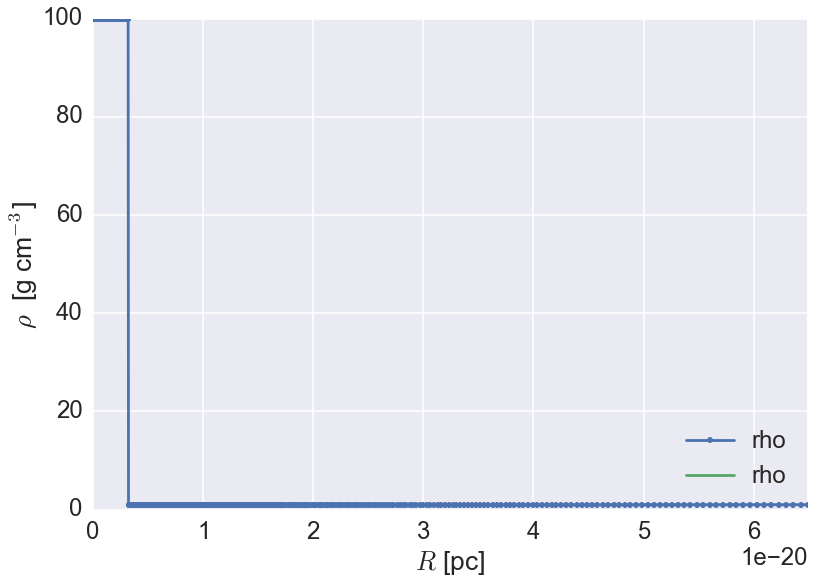

In [92]:
label_dict = {"R":"$R$ [pc]", 
              "U": r"$U$ [cm s$^{-1}$]",
              "rho": r"$\rho$  [g cm$^{-3}$]",
              "T": r"$T$ [K]",
              "Mass" : r"$M$ [$M_\odot$]",
              "C_ad": r"$C_{ad}$ [cm s$^{-1}$]",
              "E": r"$E_{int}$ [erg g$^{-1}$]",
              "P": r"$P$ [dyne cm$^{-2}$]",
              "Q": r"$Q$ [dyne cm$^{-2}$]",
              "S": r"$S$ [$k_b$ / particle]",
              "M_int": r"$M_{int}$ [$M_\odot$]",
              "dE": r"$dE$ [erg g$^{-1}$]",
             }

zones_or_edges = {"R"     : edges, 
                  "U"     : edges,
                  "rho"   : zones,
                  "T"     : zones,
                  "Mass"  : zones,
                  "C_ad"  : zones,
                  "E"     : zones,
                  "P"     : zones,
                  "Q"     : zones,
                  "S"     : zones,
                  "dE"    : zones
             }


def plot_var(var="rho", R_as_x=True, with_sedov=True, k=0, factor=1.00):
    print("current time: " + str(df_info.iloc[k].time_total / yr) + " yr")
    print("energy conserved to: ", (df_info.iloc[k].E_tot / df_info.iloc[0].E_tot) - 1)
    
    marker="."
    
    if with_sedov is True:
        sedov = dimensionalize_sedov.main(df_info.iloc[k].time_total)
        sedov = np.array(sedov).transpose()
        df_sedov = pd.DataFrame.from_records(sedov, columns=["R", "U", "rho", "T", "C_ad", "E", "P", "S", "Mass"])
        df_sedov.R /= pc
        df_sedov.R *= factor
        df_sedov.Mass /= M_solar
        df_sedov.set_index(['R'], inplace=True)
        df_sedov["M_int"] = df_sedov.Mass.cumsum()
    
    df = zones_or_edges[var]
    if R_as_x is True:
        df[df.k==ks[k]][var].plot(label="numeric", marker=marker)
    else:
#         plt.plot(df[df.k==ks[k]].i, df[df.k==ks[k]][var],label="numeric",marker=marker)
        plt.plot(M_int, df[df.k==ks[k]][var],label="numeric",marker=marker)
        plt.xlabel(label_dict["M_int"])
        plt.xscale("linear")
    
    if with_sedov is True and ((var!="Q") and (var is not "Mass") and (var is not "dE")):
        if R_as_x is True:
            df_sedov[var].plot(label="analytic")
        else:
            plt.plot(df_sedov.M_int, df_sedov[var], label="analytic")
    if R_as_x is True:
        plt.xlabel(label_dict["R"])
    else:
#         plt.xlabel("zone number")
#         plt.xscale("linear")
        pass
    plt.ylabel(label_dict[var])
    if (var is "dE") or (var is "S"):
        plt.yscale("linear")
    else:
        plt.yscale("log")
    plt.legend(loc="lower right")
    plt.xlim((0,.2 / pc))
#     plt.ylim(1e-5, 1e5)
    plt.yscale("linear")

    
interact(plot_var,
         var=variables_velos,
         R_as_x = True,
         with_sedov = True,
         k=(0,len(ks)-1),
        factor=(.75, 1.25, .1) )







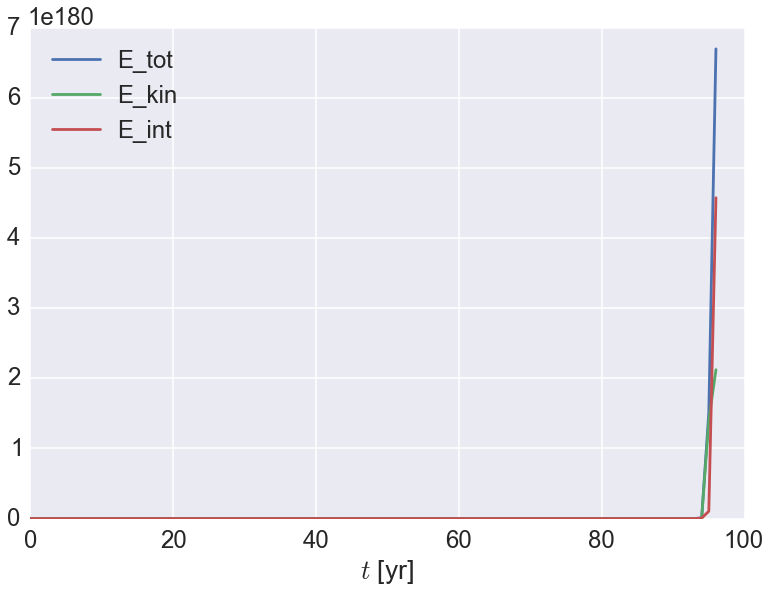

In [37]:
plt.figure()

x_data = df_info.time_total/ yr 
x_data = df_info.index

plt.plot(x_data, df_info.E_tot / df_info.E_tot[0], label="E_tot")
plt.plot(x_data, df_info.E_kin / df_info.E_tot[0], label="E_kin")
plt.plot(x_data, df_info.E_int / df_info.E_tot[0], label="E_int")
plt.xlabel(r"$t$ [yr]")
# plt.ylim((0,1.2))
plt.legend(loc="best")


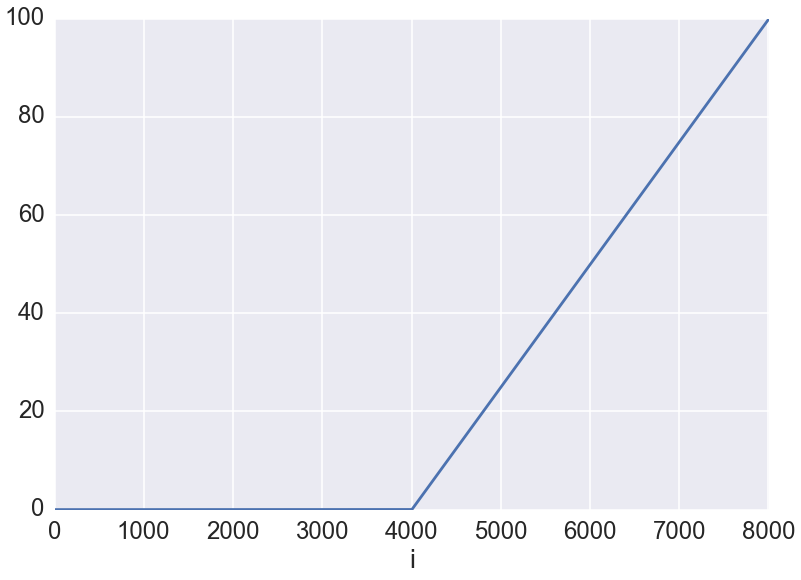

In [43]:
df_velos[df_velos.k==0].R.plot()

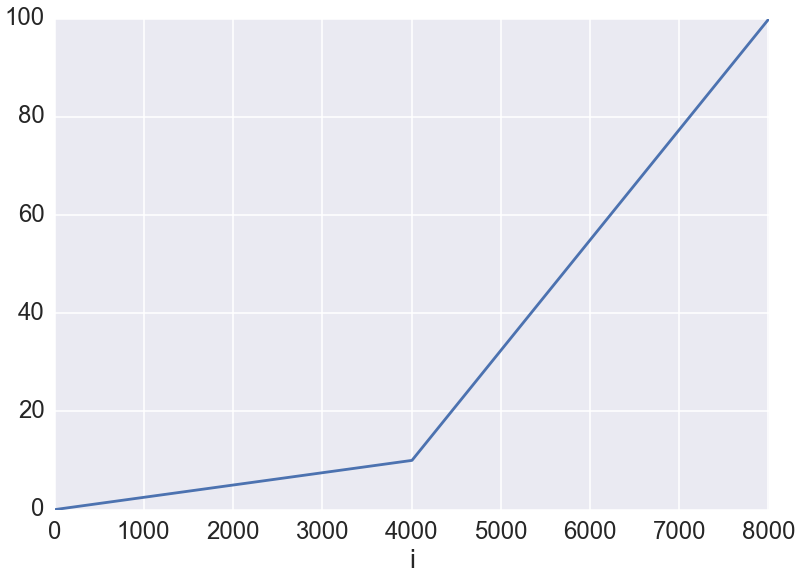

In [26]:
df_velos[df_velos.k==0].R.plot()